# Customer Segmentation of a Mall

## --- Problem definition ---

The mall holds some information about its clients, e.g. gender, age, aunnual income and spending score. These clients have subscribed to the membership card. 
When the clients subscribed to the membership card, they provided all the information. Beause they have this card they use it to buy all sorts of things in the mall
and therefore the mall has the purchase history of each of its client member. That is how they obtained the spending score.
Spending score is a score that the mall computed for each of their clients based on severlal criteria including for example thier income, 
the number of times per week they shop in the mall and of course the amount of money they spend in a year. And based on all this they computed this metric that takes
values between 1 and 100, so that the closer the spending score is to 1, the less the client spends and the closed the spending score is to 100,
the more the client spends.

The goal of this project is to find customer segments based on all these information, describe them and analyze spending score in each segment.
Solution should be delivered in a form, in which it allows easily repeat the segmentation excercise and allow quick and automated labeling of each new customer.


## --- Solution ---

In [1]:
'''This script loads and segment customer data, describe segments, label data based on the segment and saves segments centroids for future used on new data'''
   
__author__ = 'Ivana Hybenova'
__email__ = 'ivana.hybenova1@gmail.com'

### Import packages

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pickle
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Define Data class

In [3]:
class Data:
    def __init__(self, from_database=False, path_to_file=None, sql_query=None, database_credentials = None, cat_cols=None, num_cols = None):
        '''Creates dataframe with customers'''
        # create new copies instead of references
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.from_database = from_database
        self.path_to_file = path_to_file
        self.sql_query = sql_query
        self.database_credentials = database_credentials
        self.data, self.dummy_cols, self.scaled_cols, self.scaler_mapper = self._create_data()
        self.kmeans = None
                   
    def elbow_method(self, k):
        '''Calculates and plot within clusters sum of squares for passed number of clusters'''
        # array to save within clusters sum of squares
        wcss = []  
        for i in range(1, k+1):
            kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
            kmeans.fit(self.data[self.dummy_cols + self.scaled_cols])
            wcss.append(kmeans.inertia_)  # intertia computes wcss
            
        self._plot_elbow_method(k = k, wcss = wcss)
    
    def get_clusters(self, n_clusters):
        '''Runs KMeans clustering and add cluster column to the dataframe'''
        # Applying k-means to the mall dataset
        kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        self.data['segment'] = kmeans.fit_predict(self.data[self.dummy_cols + self.scaled_cols])
        self.data['segment_origin'] = 'created'
        self.kmeans = kmeans
        print('Dataframe with added segment label:')
        print()
        display(self.data.head())
    
    def visualize_clusters(self):
        '''Uses PCA to visualize clusters on 2-dimensional picture'''
        self._run_pca()
        fig = plt.figure(figsize=(15, 10))
        plt.scatter(x='x', y='y', data=self.data, alpha=0.75, c='segment')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KMeans Clusters')
        plt.show()
        
    def describe_clusters(self, ymax = 100):
        '''Prints out percentage of each category and distribution of each numerical feature for each cluster'''
        for cluster in self.data['segment'].sort_values().unique():
            data_cluster = self.data[self.data['segment'] == cluster].copy()
            print('Segment: ' + str(cluster) + '    ' + 'Number of Customers: ' + str(len(data_cluster)))
            self._cat_features_summary(data_cluster)
            cluster_describe_df = pd.DataFrame(columns = ['measure'])
            cluster_describe_df['measure'] = ['Min value', '25 %', '50 %', 'Mean', '75 %', 'Min value']
            for feature in self.num_cols:   
                cluster_describe_df[feature]= [round(data_cluster[feature].min(),0), round(data_cluster[feature].quantile(.25),0), round(data_cluster[feature].quantile(.50),0), round(data_cluster[feature].mean(),0), 
                                               round(data_cluster[feature].quantile(.75),0), round(data_cluster[feature].min(),0)]
            display(cluster_describe_df)
            plt.figure(figsize = (25,3))
            i = 1
            for feature in self.num_cols:  
                plt.subplot(1, len(self.num_cols), i)
                i += 1
                plt.hist(data_cluster[feature], bins = 20)
                plt.xlim(0, self.data[feature].max())
                plt.ylim(0,ymax)
                plt.ylabel('Counts')
                plt.xlabel(feature)
            plt.show()
            
    def save_segmented_data_model(self):
        '''Saves dataset with added segments and column labeling them as the cases that were used to create segments and model'''
        if self.from_database:
                # replacing the original dataframe to the warehouse
                engine = create_engine(engine_link = self.database_credentials[engine].item())  
                print("Overwriting database in the warehouse")
                self.data.drop(self.dummy_cols + self.scaled_cols +['x','y'], axis = 1).to_sql('customers', engine, if_exists='replace',index=False, method = 'multi')    
                engine.dispose()
                
                
                # saving the model and scaler_mapper                
                conn = psycopg2.connect(host = self.database_credentials[host].item(),
                                        database = self.database_credentials[database].item(), 
                                        user = self.database_credentials[user].item(), 
                                        password = self.database_credentials[password].item())
                cur = conn.cursor()

                #### # Assuming you have a postgres table with columns epoch and file
                pickled_model = pickle.dumps(self.kmeans)
                pickled_scaler_mapper = pickle.dumps(self.scaler_mapper)
                sql = "INSERT INTO models (model_name, model_file, scaler_filer)  VALUES(%s, %s, %s)"
                cur.execute(sql, ('customer_segmentation', psycopg2.Binary(pickled_model), psycopg2.Binary(pickled_scaler_mapper)))
                connection.commit() 
                
                cur.close()
                conn.close()
        else:
            self.data.drop(self.dummy_cols + self.scaled_cols +['x','y'], axis = 1).to_csv(self.path_to_file, index = False)
            pickle.dump(self.kmeans, open('model.pkl', 'wb'))
            pickle.dump(self.scaler_mapper, open('scaler_mapper.pkl', 'wb'))
    
    def _create_data(self):
        '''Loads dataframe from csv file or a database and dummy encode categorical variables'''
        if self.from_database:
            conn = psycopg2.connect(host = self.database_credentials[host].item(),
                                    database = self.database_credentials[database].item(), 
                                    user = self.database_credentials[user].item(), 
                                    password = self.database_credentials[password].item())

            # creates a new cursor used to execute SELECT statements
            cur = conn.cursor()
            # creating the query 
            postgreSQL_select_Query = self.sql_query
            # quering the data
            cur.execute(postgreSQL_select_Query)
            data = cur.fetchall() 

            # puting data into a dataframe
            data = pd.DataFrame.from_records(data, columns = ['customer_id', 'gender', 'age', 'annual_income_thousands', 'spending_score'])
            
            cur.close()
            conn.close()

        else:
            data = pd.read_csv(path_to_file)
        print('Data from the csv file/database:')
        display(data.head())
        print()
        data, dummy_cols = self._dummy_encode(data, self.cat_cols)
        print('Data with extra dummy columns:')
        display(data.head())
        print()
        data, scaled_cols, scaler_mapper = self._scale_data(data, dummy_cols)
        print('Data with scaled features:')
        display(data.head())
        
        return data, dummy_cols, scaled_cols, scaler_mapper
    
    def _dummy_encode(self, df, cat_cols):
        '''Adds to dataframe add to the dummy columns for each categorical variable and returns array with their names'''
        dummy_cols = []
        for col in cat_cols:
            df_col_dummy = pd.get_dummies(df[col])
            dummy_cols.extend(df_col_dummy.columns)
            df = pd.concat([df, df_col_dummy], axis = 1, sort = False)
        return df, dummy_cols
    
    def _scale_data(self, data, dummy_cols):
    #    scaler = scale()
        scaled_cols = []
        for col in self.num_cols:
            column = str(col + '_scaled')
            scaled_cols.append(column)
            data[column] = data[col]
        df = data[dummy_cols + scaled_cols]
        scaler_mapper = DataFrameMapper([(df.columns, StandardScaler())])
        scaled_features = scaler_mapper.fit_transform(df.copy())
        data[dummy_cols + scaled_cols] = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

        return data, scaled_cols, scaler_mapper

    def _plot_elbow_method(self, k, wcss):
        '''Plots visualization based on which optimal number of clusters can be picked'''
        plt.figure(figsize=(15,10))
        plt.plot(range(1, k+1), wcss)
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        
    def _run_pca(self):
        '''Runs PCA, to transform the features into 2 components, which coordinates are added to the dataframe'''
        # Principal component separation to create a 2-dimensional picture
        pca = PCA(n_components = 2)
        self.data['x'] = pca.fit_transform(self.data[self.scaled_cols + self.dummy_cols])[:,0]
        self.data['y'] = pca.fit_transform(self.data[self.scaled_cols + self.dummy_cols])[:,1]
        self.data = self.data.reset_index(drop = True)
        
    def _cat_features_summary(self, data_cluster):
        '''Creates string with summary of categorical features of given cluster'''
        for cat_feature in self.cat_cols:
            data_cluster['count'] = data_cluster[cat_feature]
            data_cluster_grouped = data_cluster[[cat_feature, 'count']].groupby(cat_feature).count().reset_index()
            data_cluster_grouped['percentage'] = round(data_cluster_grouped['count'].astype(int) / data_cluster_grouped['count'].astype(int).sum() * 100,0)
            display(data_cluster_grouped)
        
        

### Define parameters to load customers dataframe and run segmentation

In [4]:
# number of clusters for elbow method
k = 10

# path to the dataset
path_to_file = 'Mall_Customers.csv'

# Boolean value, whether dataset should be pulled from the database (PostgreSQL)
from_database = False

## Credentials to create connection to the database with psycopg2 and sqlalchemy
#database_credentials = pd.DataFrame({
#    'host': [os.environ['HOST_WAREHOUSE']],
#    'database': [os.environ['NAME_WAREHOUSE']],
#    'user': [os.environ['USER_WAREHOUSE']],
#    'password': [os.environ['PASSWORD_WAREHOUSE']],
#    'engine': [os.environ['ENGINE_WAREHOUSE']]
#})

## SQL query to download customers table
## Make sure to download the whole table as the original one will get replaced, not only specified features will be used
#sql_query =  """
#               SELECT *
#               FROM customers
#             """     

# Names of categorical features
categorical_features = ['gender']

# Names of numerical features
numerical_features = ['age', 'annual_income_thousands', 'spending_score']



### Create Data object

In [5]:
data = Data(from_database=from_database, path_to_file=path_to_file, cat_cols=categorical_features, num_cols=numerical_features)

Data from the csv file/database:


,customer_id,gender,age,annual_income_thousands,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Data with extra dummy columns:


,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male
0,1,Male,19,15,39,0,1
1,2,Male,21,15,81,0,1
2,3,Female,20,16,6,1,0
3,4,Female,23,16,77,1,0
4,5,Female,31,17,40,1,0



Data with scaled features:


,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male,age_scaled,annual_income_thousands_scaled,spending_score_scaled
0,1,Male,19,15,39,-1.128152,1.128152,-1.424569,-1.738999,-0.434801
1,2,Male,21,15,81,-1.128152,1.128152,-1.281035,-1.738999,1.195704
2,3,Female,20,16,6,0.886405,-0.886405,-1.352802,-1.700830,-1.715913
3,4,Female,23,16,77,0.886405,-0.886405,-1.137502,-1.700830,1.040418
4,5,Female,31,17,40,0.886405,-0.886405,-0.563369,-1.662660,-0.395980


### Find optimal number of clusters with Elbow curve

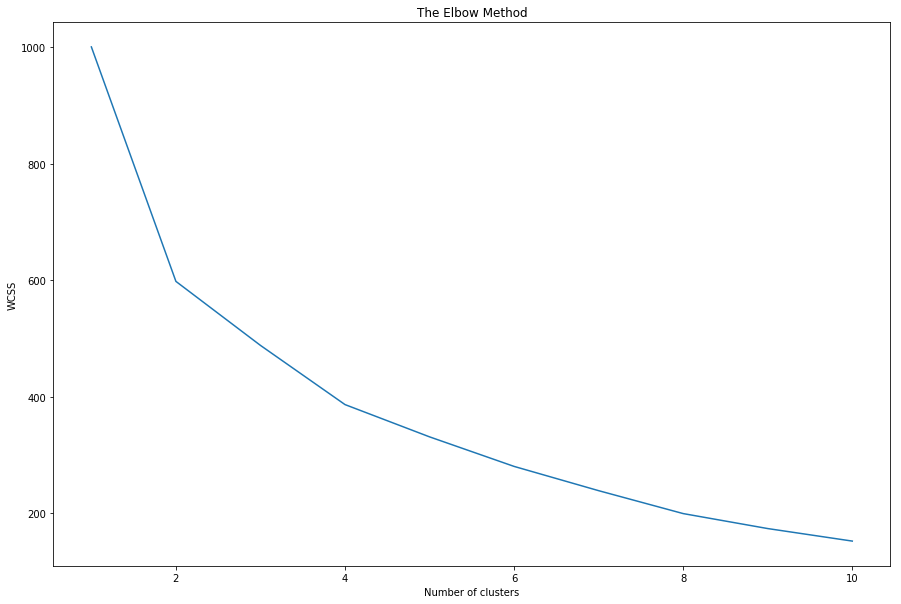

In [6]:
data.elbow_method(k = 10)

### Run customers segmentation with chosen number of clusters

In [7]:
data.get_clusters(n_clusters = 4)

Dataframe with added segment label:



,customer_id,gender,age,annual_income_thousands,spending_score,Female,Male,age_scaled,annual_income_thousands_scaled,spending_score_scaled,segment,segment_origin
0,1,Male,19,15,39,-1.128152,1.128152,-1.424569,-1.738999,-0.434801,3,created
1,2,Male,21,15,81,-1.128152,1.128152,-1.281035,-1.738999,1.195704,3,created
2,3,Female,20,16,6,0.886405,-0.886405,-1.352802,-1.700830,-1.715913,1,created
3,4,Female,23,16,77,0.886405,-0.886405,-1.137502,-1.700830,1.040418,2,created
4,5,Female,31,17,40,0.886405,-0.886405,-0.563369,-1.662660,-0.395980,2,created


### Visualize the segments in 2-dimensional feature space (after PCA transormation)

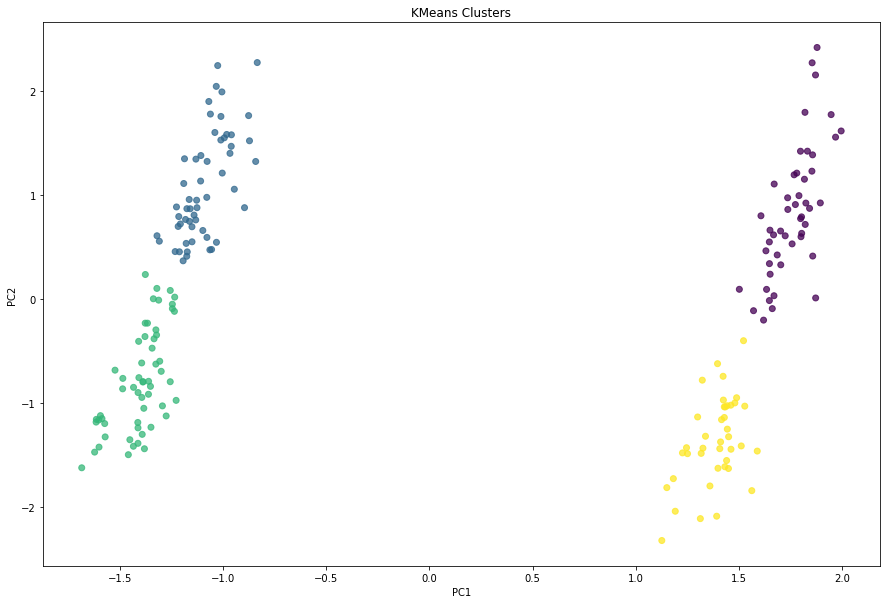

In [8]:
data.visualize_clusters()

### Describe each segment

Segment: 0    Number of Customers: 48


,gender,count,percentage
0,Male,48,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,19.0,19.0,1.0
1,25 %,40.0,46.0,12.0
2,50 %,48.0,62.0,32.0
3,Mean,49.0,62.0,29.0
4,75 %,59.0,78.0,46.0
5,Min value,19.0,19.0,1.0


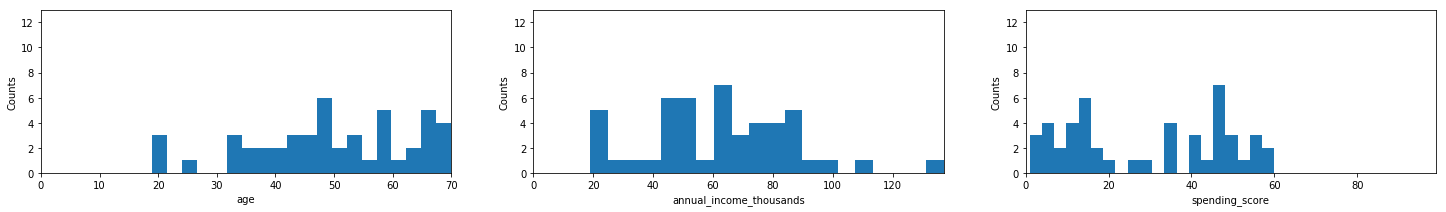

Segment: 1    Number of Customers: 55


,gender,count,percentage
0,Female,55,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,20.0,16.0,5.0
1,25 %,42.0,41.0,21.0
2,50 %,49.0,57.0,39.0
3,Mean,48.0,59.0,35.0
4,75 %,54.0,74.0,48.0
5,Min value,20.0,16.0,5.0


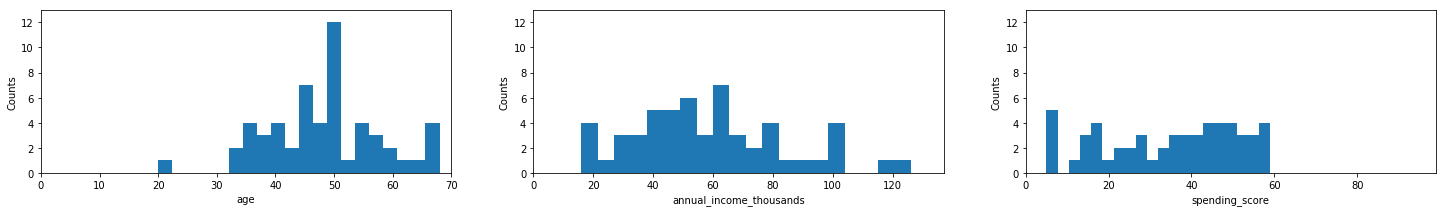

Segment: 2    Number of Customers: 57


,gender,count,percentage
0,Female,57,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,18.0,16.0,29.0
1,25 %,23.0,39.0,51.0
2,50 %,30.0,62.0,73.0
3,Mean,28.0,60.0,68.0
4,75 %,32.0,78.0,83.0
5,Min value,18.0,16.0,29.0


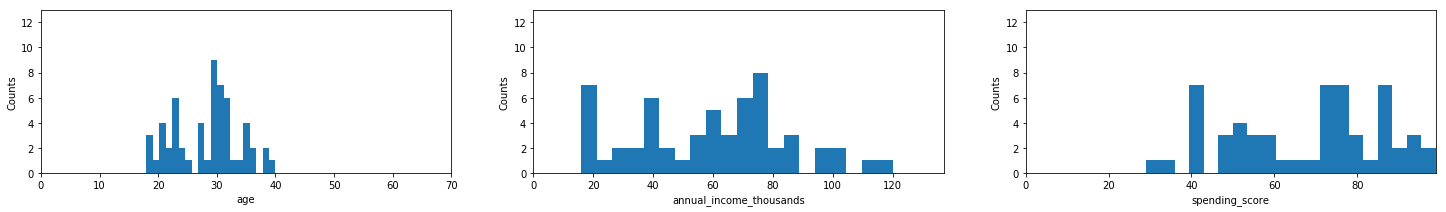

Segment: 3    Number of Customers: 40


,gender,count,percentage
0,Male,40,100.0


,measure,age,annual_income_thousands,spending_score
0,Min value,18.0,15.0,39.0
1,25 %,22.0,41.0,58.0
2,50 %,28.0,63.0,73.0
3,Mean,28.0,62.0,72.0
4,75 %,33.0,78.0,88.0
5,Min value,18.0,15.0,39.0


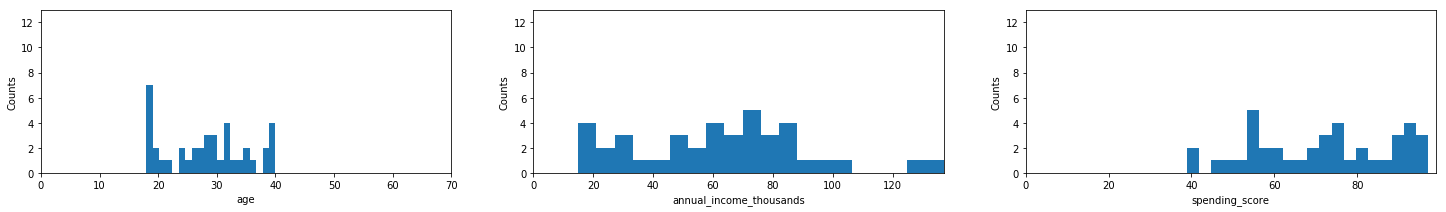

In [9]:
data.describe_clusters(ymax = 13)

#### Save the data, model and scaler mapper

In [10]:
# Rewrites existed data!
data.save_segmented_data_model()